# KMeans: Scitkit, Pilot and Spark/MLlib


This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant (see <https://archive.ics.uci.edu/ml/datasets/Iris>). 

Source: R. A. Fisher, The Use of Multiple Measurements in Taxonomic Problems, 1936, http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf

Pictures (Source [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

<table>
<tr><td>
Setosa
</td><td>
Versicolor
</td><td>
Virginica
</td></tr>
<tr><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"/> 
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/320px-Iris_versicolor_3.jpg"/>
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg"/>
</td></tr></table>

## 1. Data Overview

In [22]:
%matplotlib inline
import pandas as pd
import seaborn as sns

In [61]:
data = pd.read_csv("https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv")
data.head()

SepalLength  SepalWidth  PetalLength  PetalWidth         Name
0          5.1         3.5          1.4         0.2  Iris-setosa
1          4.9         3.0          1.4         0.2  Iris-setosa
2          4.7         3.2          1.3         0.2  Iris-setosa
3          4.6         3.1          1.5         0.2  Iris-setosa
4          5.0         3.6          1.4         0.2  Iris-setosa

## 2. Scikit

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
results = kmeans.fit_predict(data[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']])

In [7]:
data_kmeans=pd.concat([data, pd.Series(results, name="ClusterId")], axis=1)
data_kmeans.head()

SepalLength  SepalWidth  PetalLength  PetalWidth         Name  ClusterId
0          5.1         3.5          1.4         0.2  Iris-setosa          0
1          4.9         3.0          1.4         0.2  Iris-setosa          0
2          4.7         3.2          1.3         0.2  Iris-setosa          0
3          4.6         3.1          1.5         0.2  Iris-setosa          0
4          5.0         3.6          1.4         0.2  Iris-setosa          0

In the following we evaluate the model using the sum of squared error and a pair plot. The following pairplots show the scatter-plot between each of the four features. Clusters for the different species are indicated by the color.

In [8]:
print "Sum of squared error: %.1f"%kmeans.inertia_

Sum of squared error: 78.9


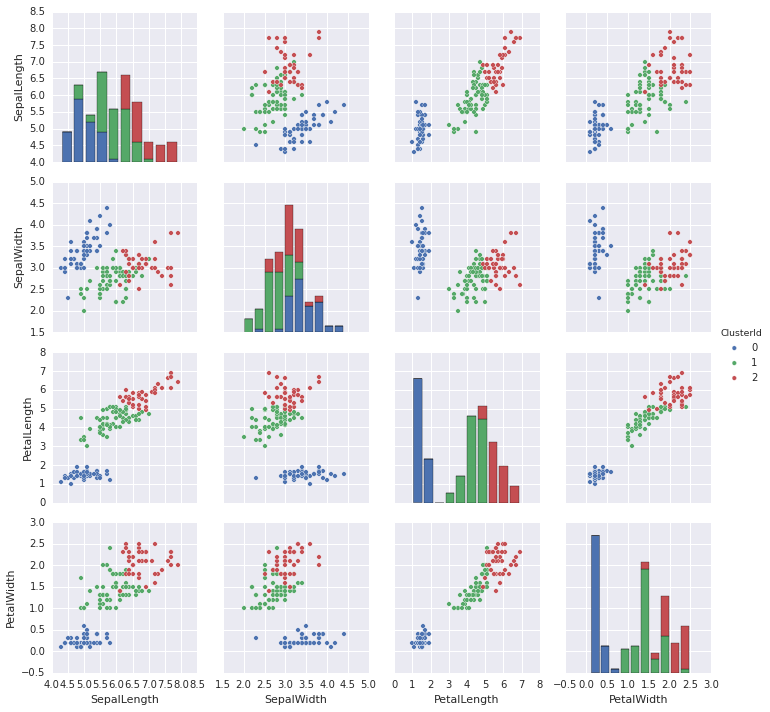

In [16]:
sns.pairplot(data_kmeans, vars=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"], hue="ClusterId");

## 3. Pilot Approach

In [80]:
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import euclidean_distances

def mapper(data, centroids):
    # compute distances between all points and centroids
    distance = sklearn.metrics.pairwise.euclidean_distances(data, clusters)
    # compute cluster with min distance
    cluster_id = np.argmin(distance, axis=1)
    # reshape to row vector
    cluster_id = cluster_id[:, np.newaxis]
    # join data and cluster ids
    data=np.column_stack((data, cluster_id))
    return data


def compute_new_centroids(distances):
    df = pd.DataFrame(distances)
    df[3] =  df[3].astype(int)
    df = df.groupby(3)[0,1,2].mean()
    centroids_np = df.as_matrix()
    return centroids_np

In [ ]:
import os, sys
import commands
import radical.pilot as rp
os.environ["RADICAL_PILOT_DBURL"]="mongodb://ec2-54-221-194-147.compute-1.amazonaws.com:24242/giannis"
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "local.localhost"
pdesc.runtime  = 10 
pdesc.cores    = 16
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
umgr.add_pilots(pilot)

Partition data and distribute to a set of CUs for fast processing

In [64]:
number_clusters = 3
clusters = data.sample(number_clusters)

In [65]:
clusters

SepalLength  SepalWidth  PetalLength  PetalWidth            Name
25           5.0         3.0          1.6         0.2     Iris-setosa
120          6.9         3.2          5.7         2.3  Iris-virginica
37           4.9         3.1          1.5         0.1     Iris-setosa

In [66]:
clusters.to_csv("clusters.csv")
data.to_csv("points.csv")

In [67]:
distances = !/opt/anaconda/envs/python2/bin/python mapper.py points.csv clusters.csv
#distances = !python mapper.py points.csv clusters.csv

In [81]:
distances_np = np.fromstring(" ".join(distances))

In [76]:
type(distances_np)

numpy.ndarray

In [82]:
length=len(distances_np)/number_clusters
distances_array=distances_np.reshape((length, number_clusters))

In [83]:
compute_new_centroids(distances_array)

KeyError: 3

In [20]:
for i in range(10):
    points_cluster = mapper(data, clusters) 
    new_centroids = compute_new_centroids(points_cluster)
    clusters=new_centroids

NameError: name 'data' is not defined

## Spark MLLib

In [1]:
from numpy import array
from math import sqrt

%run ../env.py
%run ../util/init_spark.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "yarn-client://sc15.radical-cybertools.org",
    "number_of_processes": 5
}
pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()
sqlCtx=SQLContext(sc)

SPARK Home: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6


In [5]:
# Load and parse the data
data_spark=sqlCtx.createDataFrame(data)
data_spark_without_class=data_spark.select('SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth').show()

+-----------+----------+-----------+----------+
|SepalLength|SepalWidth|PetalLength|PetalWidth|
+-----------+----------+-----------+----------+
|        5.1|       3.5|        1.4|       0.2|
|        4.9|       3.0|        1.4|       0.2|
|        4.7|       3.2|        1.3|       0.2|
|        4.6|       3.1|        1.5|       0.2|
|        5.0|       3.6|        1.4|       0.2|
|        5.4|       3.9|        1.7|       0.4|
|        4.6|       3.4|        1.4|       0.3|
|        5.0|       3.4|        1.5|       0.2|
|        4.4|       2.9|        1.4|       0.2|
|        4.9|       3.1|        1.5|       0.1|
|        5.4|       3.7|        1.5|       0.2|
|        4.8|       3.4|        1.6|       0.2|
|        4.8|       3.0|        1.4|       0.1|
|        4.3|       3.0|        1.1|       0.1|
|        5.8|       4.0|        1.2|       0.2|
|        5.7|       4.4|        1.5|       0.4|
|        5.4|       3.9|        1.3|       0.4|
|        5.1|       3.5|        1.4|    

### Convert DataFrame to Tuple for MLlib

In [6]:
data_spark_tuple = data_spark.map(lambda a: (a[0],a[1],a[2],a[3]))

In [7]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(data_spark_tuple, 3, maxIterations=10,
                        runs=10, initializationMode="random")

In [10]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data_spark_tuple.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 97.3259242343
